In [20]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [21]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [22]:
# Load data
data_train = pd.read_csv('../Data Splits/train_data_60_40.csv')
data_val = pd.read_csv('../Data Splits/val_data_60_40.csv')

In [23]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [24]:
# Text preprocessing
def remove_diacritics(text):
    normalized = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

def wordopt(text):
    text = text.lower()
    text = remove_diacritics(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [25]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [26]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_val_processed = [' '.join(tokens) for tokens in X_val]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_val_tfidf:", X_val_tfidf.shape)

Shape of X_train_tfidf: (1731, 26336)
Shape of X_val_tfidf: (1154, 26336)


In [27]:
training = pd.read_csv('../Data Splits/test_data.csv')

training_x = training['article']

traning_y = training['article']

training_x = training_x.apply(preprocess)

training_processed = [' '.join(tokens) for tokens in training_x]
training_tfidf = tfidf_vectorizer.transform(training_processed)
print("Shape of X_val_tfidf:", training_tfidf.shape)

Shape of X_val_tfidf: (321, 26336)


In [28]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [29]:
# Define the parameter grid
param_grid = {'penalty': ['l2'], 'C': [1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear']}

# Define the GridSearchCV
# lr_grid = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [30]:
# lr_grid.fit(X_train_tfidf, y_train)

In [31]:
# print("Best Hyperparameters: ", lr_grid.best_params_)
# print("Best Accuracy: {:.2f}%".format(lr_grid.best_score_ * 100))

In [32]:
# best_meta = lr_grid.best_estimator_
# joblib.dump(best_meta, '../Models/60-40 Test/stackmodel_lr_best_estimator.joblib')

In [33]:
best_meta = joblib.load('../Models/60-40 Test/stackmodel_lr_best_estimator.joblib')
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=LogisticRegression(C=1000))

Metrics for predict_proba:
Accuracy: 0.8509532062391681
Precision: 0.7824267782426778
Recall: 0.9722703639514731
F1 Score: 0.8670788253477589
AUC: 0.9705612908457959
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       577
           1       0.78      0.97      0.87       577

    accuracy                           0.85      1154
   macro avg       0.87      0.85      0.85      1154
weighted avg       0.87      0.85      0.85      1154



C:\Users\User\AppData\Local\Temp\ipykernel_6288\1857348846.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]


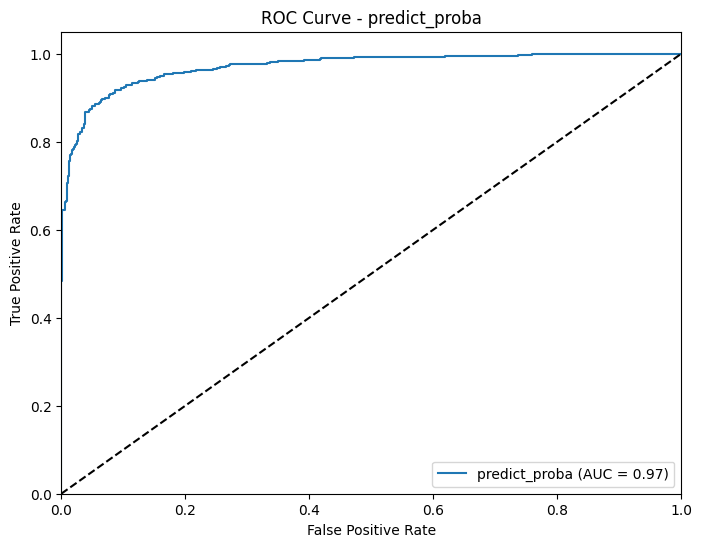

Metrics for predict_proba:
Accuracy: 0.9280762564991335
Precision: 0.9591078066914498
Recall: 0.8942807625649913
F1 Score: 0.9255605381165919
AUC: 0.9834499247587324
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       577
           1       0.96      0.89      0.93       577

    accuracy                           0.93      1154
   macro avg       0.93      0.93      0.93      1154
weighted avg       0.93      0.93      0.93      1154



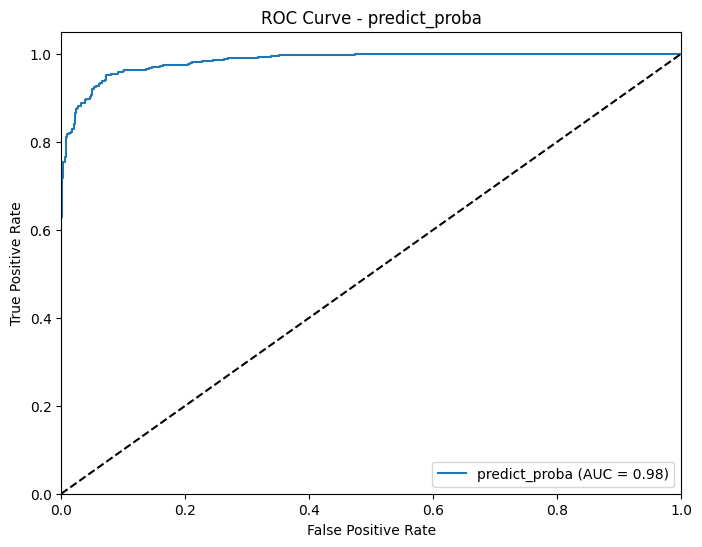

Metrics for predict_proba:
Accuracy: 0.9324090121317158
Precision: 0.9463327370304114
Recall: 0.9168110918544194
F1 Score: 0.9313380281690141
AUC: 0.9866307831399488
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       577
           1       0.95      0.92      0.93       577

    accuracy                           0.93      1154
   macro avg       0.93      0.93      0.93      1154
weighted avg       0.93      0.93      0.93      1154



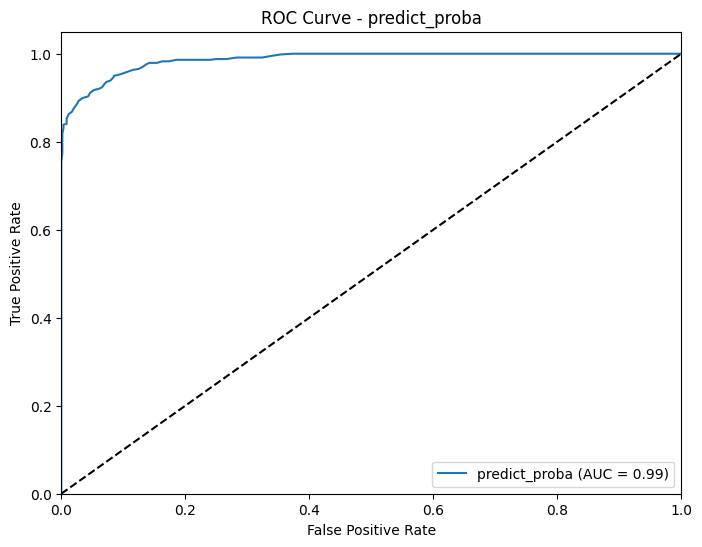

Metrics for predict_proba:
Accuracy: 0.8552859618717504
Precision: 0.8068862275449101
Recall: 0.9341421143847487
F1 Score: 0.8658634538152611
AUC: 0.9419876309963986
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       577
           1       0.81      0.93      0.87       577

    accuracy                           0.86      1154
   macro avg       0.86      0.86      0.85      1154
weighted avg       0.86      0.86      0.85      1154



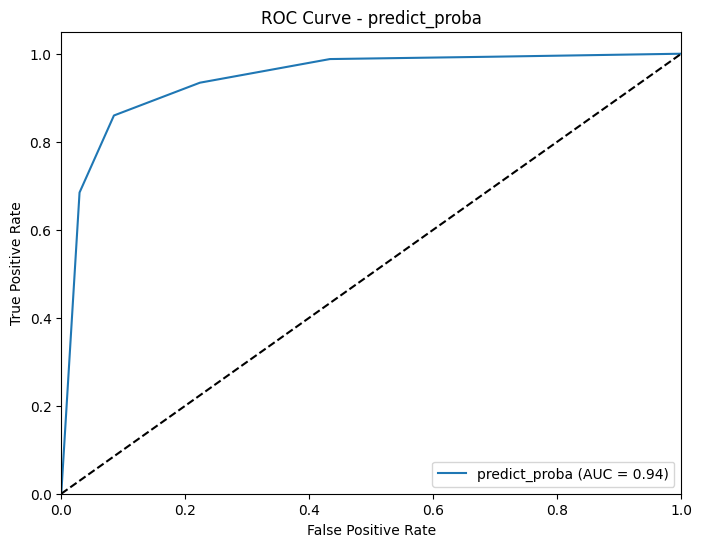

Metrics for predict_proba:
Accuracy: 0.9428076256499134
Precision: 0.9757914338919925
Recall: 0.9081455805892548
F1 Score: 0.940754039497307
AUC: 0.9880890520201004
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       577
           1       0.98      0.91      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



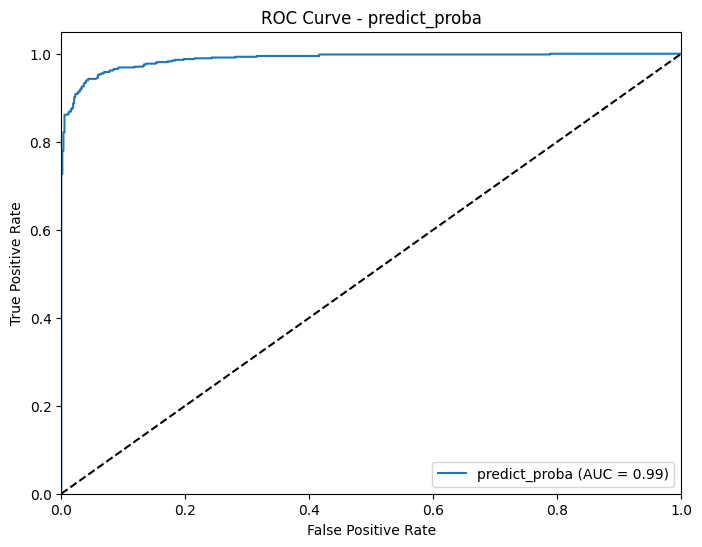

In [39]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(stack.estimators_ , stack.stack_method_):
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

In [41]:
# Evaluate stacking model
# stack_y_pred = stack.predict(X_val_tfidf)
# stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

# stack_accuracy = accuracy_score(y_val, stack_y_pred)
# stack_precision = precision_score(y_val, stack_y_pred)
# stack_recall = recall_score(y_val, stack_y_pred)
# stack_f1 = f1_score(y_val, stack_y_pred)
# stack_auc = roc_auc_score(y_val, stack_y_prob)

# print("Metrics for Stacking Model:")
# print(f"Accuracy: {stack_accuracy}")
# print(f"Precision: {stack_precision}")
# print(f"Recall: {stack_recall}")
# print(f"F1 Score: {stack_f1}")
# print(f"AUC: {stack_auc}")
# print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# # ROC Curve for stacking model
# stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
# stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# # Store stacking model metrics in the DataFrame
# metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# # Plot ROC Curve for stacking model
# plt.figure(figsize=(8, 6))
# plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Stacking Model')
# plt.legend(loc="lower right")
# plt.show()

# # Display the comparison table
# print("Comparison of Models:")
# print(metrics_df)

Metrics for MNB:
Accuracy: 0.8509532062391681
Precision: 0.7824267782426778
Recall: 0.9722703639514731
F1 Score: 0.8670788253477589
AUC: 0.9705612908457959
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83       577
           1       0.78      0.97      0.87       577

    accuracy                           0.85      1154
   macro avg       0.87      0.85      0.85      1154
weighted avg       0.87      0.85      0.85      1154



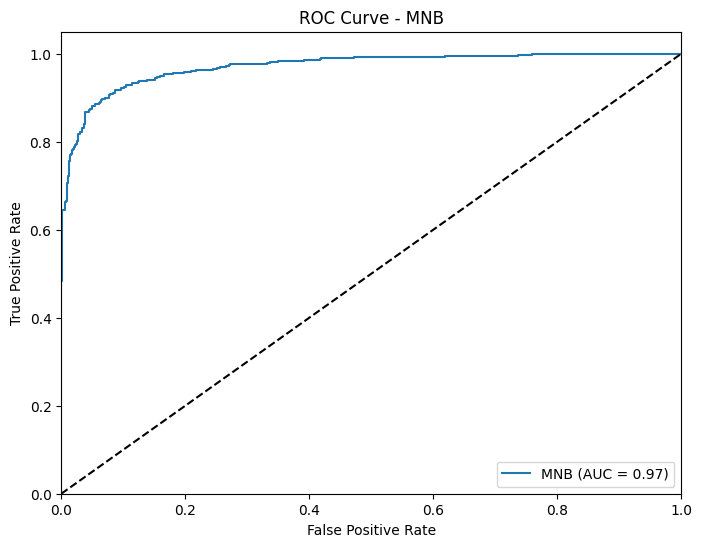

Metrics for LR:
Accuracy: 0.9280762564991335
Precision: 0.9591078066914498
Recall: 0.8942807625649913
F1 Score: 0.9255605381165919
AUC: 0.9834499247587324
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       577
           1       0.96      0.89      0.93       577

    accuracy                           0.93      1154
   macro avg       0.93      0.93      0.93      1154
weighted avg       0.93      0.93      0.93      1154



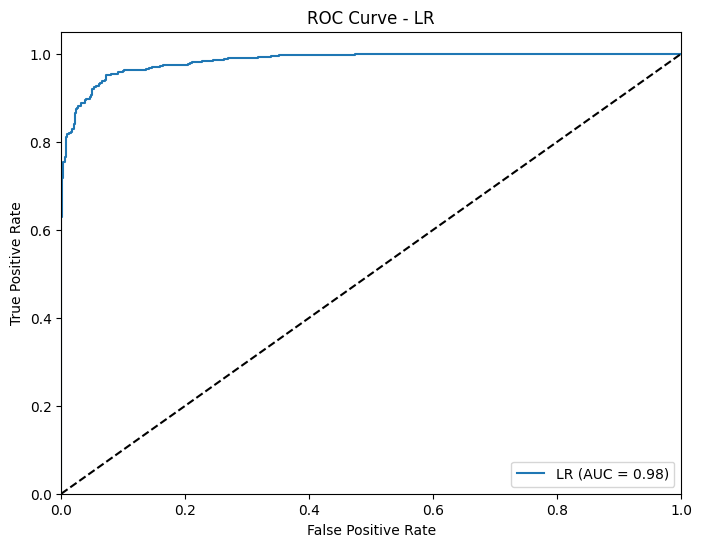

Metrics for RF:
Accuracy: 0.9393414211438474
Precision: 0.9534883720930233
Recall: 0.9237435008665511
F1 Score: 0.9383802816901409
AUC: 0.9873336357001041
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       577
           1       0.95      0.92      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



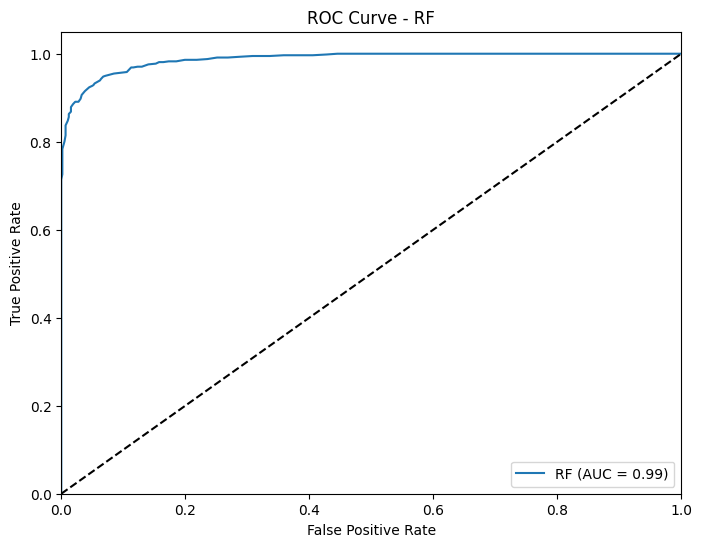

Metrics for KNN:
Accuracy: 0.8552859618717504
Precision: 0.8068862275449101
Recall: 0.9341421143847487
F1 Score: 0.8658634538152611
AUC: 0.9419876309963986
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       577
           1       0.81      0.93      0.87       577

    accuracy                           0.86      1154
   macro avg       0.86      0.86      0.85      1154
weighted avg       0.86      0.86      0.85      1154



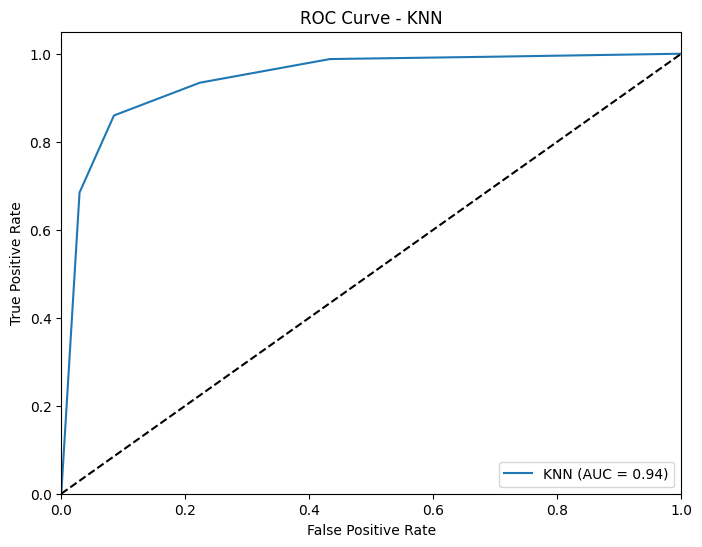

Metrics for SVM:
Accuracy: 0.9428076256499134
Precision: 0.9757914338919925
Recall: 0.9081455805892548
F1 Score: 0.940754039497307
AUC: 0.9880845465549712
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       577
           1       0.98      0.91      0.94       577

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



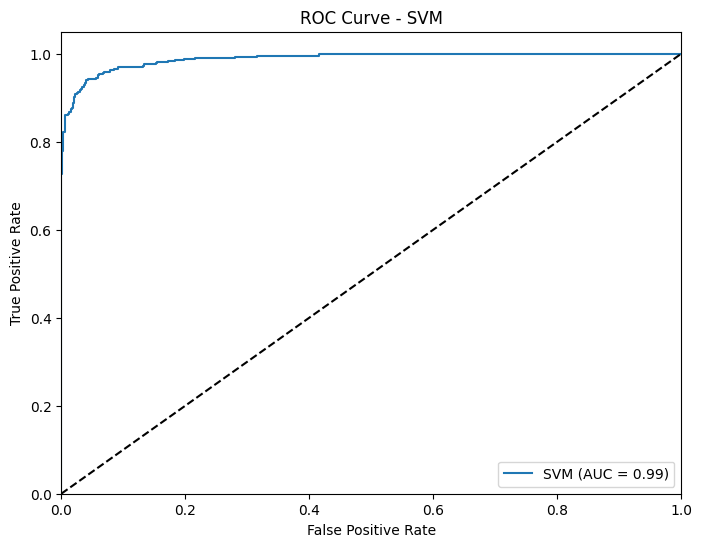

In [40]:
# # Save the model using joblib
# joblib.dump(stack, '../Models/60-40 Test/stackmodel_lr.joblib')


for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

In [44]:
new_stack = joblib.load('../Models/60-40 Test/stackmodel_lr.joblib')
new_stack.predict_proba(training_tfidf)


array([[5.32867088e-03, 9.94671329e-01],
       [9.95181899e-01, 4.81810084e-03],
       [9.64467923e-01, 3.55320766e-02],
       [7.80457533e-03, 9.92195425e-01],
       [1.48907129e-02, 9.85109287e-01],
       [8.59838017e-03, 9.91401620e-01],
       [2.18843736e-02, 9.78115626e-01],
       [8.55582127e-01, 1.44417873e-01],
       [8.86963744e-01, 1.13036256e-01],
       [8.37566580e-01, 1.62433420e-01],
       [1.31617298e-02, 9.86838270e-01],
       [1.07190327e-02, 9.89280967e-01],
       [9.97688467e-01, 2.31153312e-03],
       [6.13526507e-03, 9.93864735e-01],
       [4.28993766e-03, 9.95710062e-01],
       [9.81566406e-01, 1.84335943e-02],
       [1.08385088e-02, 9.89161491e-01],
       [9.94016181e-01, 5.98381873e-03],
       [9.99056695e-01, 9.43304774e-04],
       [1.55001120e-02, 9.84499888e-01],
       [6.44859631e-03, 9.93551404e-01],
       [4.41100499e-01, 5.58899501e-01],
       [1.30053960e-02, 9.86994604e-01],
       [1.26942199e-02, 9.87305780e-01],
       [9.897270